# Imports

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 15]

# Data

In [5]:
IMG_PATH = '../data/dss/scrolls/P123-Fg002-R-C01-R01-binarized.jpg'

def pimg(im, **kwargs):
    try:
        cim = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    except:
        cim = im
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(cim, **kwargs)
    plt.show()

def write_cc(img, cc):
    try:
        cimg = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    except:
        cimg = img
    cv.rectangle(cimg, (cc.x,cc.y), (cc.x+cc.w, cc.y+cc.h), (0,255,0), 2)
    return cimg

In [132]:
from dataclasses import dataclass, asdict
from typing import Any, Dict, List, Tuple

import cv2 as cv
import numpy as np
from peakdetect import peakdetect


@dataclass
class ConnectedComponent:
    """A dataclass that contains all information for one connected component in an image.
    """
    x: int
    y: int
    w: int
    h: int
    a: int
    cx: float
    cy: float


@dataclass
class LineSegment:
    """A dataclass that contains information necessary to put a line segment and its containing connected components
    back into the originating image.
    """
    top: ConnectedComponent
    bot: ConnectedComponent
    left: ConnectedComponent
    right: ConnectedComponent
    x_offset: int
    y_offset: int
    width: int
    height: int
    components: List[ConnectedComponent]


def get_line_image_from_ccs(image: np.ndarray, ccs_line: List[ConnectedComponent]) -> Tuple[np.ndarray, LineSegment]:
    """Given an image and a list of connected components, get a slice of the image that only contains the given
    connected components.

    :rtype: np.ndarray
    :param image: The source image.
    :param ccs_line: The connected components to slice with
    :return: A slice of the source image containing only the given connected components
    """
    topmost_cc = ccs_line[np.argmin([cc.y for cc in ccs_line])]
    bottommost_cc = ccs_line[np.argmax([cc.y + cc.h for cc in ccs_line])]
    leftmost_cc = ccs_line[np.argmin([cc.x for cc in ccs_line])]
    rightmost_cc = ccs_line[np.argmax([cc.x + cc.w for cc in ccs_line])]
    height = bottommost_cc.y + bottommost_cc.h - topmost_cc.y
    width = rightmost_cc.x + rightmost_cc.w - leftmost_cc.x
    line_image = np.zeros((height, width))
    x_offset = leftmost_cc.x
    y_offset = topmost_cc.y
    data = LineSegment(topmost_cc, bottommost_cc, leftmost_cc, rightmost_cc, x_offset, y_offset, width, height, ccs_line
                       )
    for cc in ccs_line:
        y_l = cc.y - y_offset
        x_l = cc.x - x_offset
        line_image[y_l:y_l + cc.h, x_l:x_l + cc.w] = \
            image[cc.y:cc.y + cc.h, cc.x:cc.x + cc.w]
    return line_image, data


def get_ccs_per_line(ccs: List[ConnectedComponent], minima: List[List[int]], image_height: int) \
        -> List[List[ConnectedComponent]]:
    """Given a list of connected components and a list op minima (formatted as `peakdetect.peakdetect`), order the
    connected components by the line it is contained within.

    :param ccs: The connected components
    :param minima: The list of minima (minima[x] = [location, value])
    :param image_height: The height of the source image used to determine the last line height
    :return: A list containing all connected components per line
    """
    ccs_per_line = []
    for i in range(len(minima) + 1):
        curr_line = minima[i][0] if i < len(minima) else image_height
        last_line = minima[i - 1][0] if i > 0 else 0
        ccs_curr_line = [cc for cc in ccs if last_line <= cc.cy < curr_line]
        ccs_per_line.append(ccs_curr_line)
    return ccs_per_line


def preprocessed(image: np.ndarray) -> np.ndarray:
    """Return the source image, preprocessed (converted to greyscale and thresholded).

    :param image: The source image
    :return: The preprocessed source image.
    """
    result = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, result = cv.threshold(result, 127, 255, cv.THRESH_BINARY_INV)
    result = skeletonize_pass(image)
    return result


def extract_cc(image: np.ndarray, cc: ConnectedComponent) -> np.ndarray:
    """Get a slice of an image that only contains the part that is contained within a connected component.

    :param image: The source image
    :param cc: The connected component
    :return: The image slice
    """
    return image[cc.y:cc.y + cc.h, cc.x:cc.x + cc.w]


def get_ccs_from_image(image: np.ndarray) -> np.ndarray:
    """Get all connected components of an image.

    :param image: The source image
    :return: The list of connected components
    """
    _, _, stats, centroids = cv.connectedComponentsWithStats(image)
    return [
        ConnectedComponent(*stat.tolist(), *centroids[i].tolist())
        for i, stat in enumerate(stats)
    ]


def line_segment_image(input_image: np.ndarray, peak_lookahead: int = 40, cc_min_a: int = 500, cc_max_a: int = 1e5) \
        -> Tuple[List[np.ndarray], List[Dict[str, Any]]]:
    """Perform line segmentation on an image, using the reduction method.

    :param input_image: The source image.
    :param peak_lookahead: Lookahead used by the peak detection algorithm
    :param cc_min_a: The minimum area of the connected components to use
    :param cc_max_a: The maximum area of the connected components to use
    :return: The line images and the metadata of the line segments
    """
    image = preprocessed(input_image)
    ccs = get_ccs_from_image(image)
    ccs = [cc for cc in ccs if cc_min_a <= cc.a <= cc_max_a]
    reduced = cv.reduce(image // 255, 1, cv.REDUCE_SUM, dtype=cv.CV_32S)
    _, minima = peakdetect(reduced, lookahead=peak_lookahead)
    ccs_per_line = get_ccs_per_line(ccs, minima, image.shape[1])
    lines = [
        get_line_image_from_ccs(image, ccs_line)
        for ccs_line in ccs_per_line if ccs_line
    ]
    line_images = [line[0] for line in lines]
    metadata = [asdict(line[1]) for line in lines]
    return line_images, metadata


class ProjectionSegmenter:
    pass


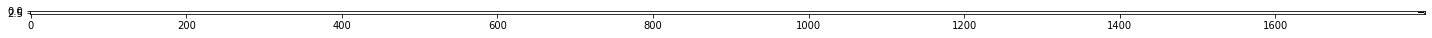

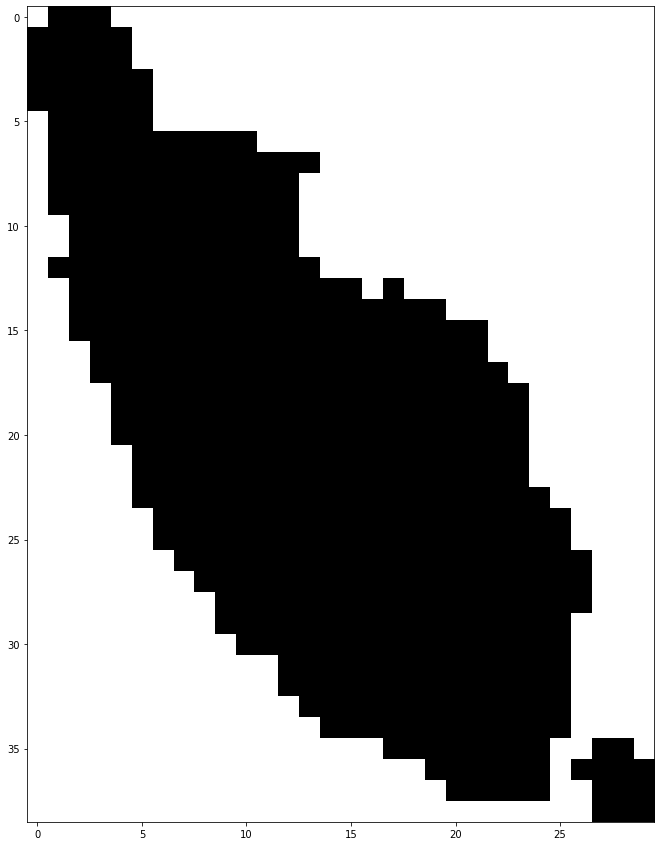

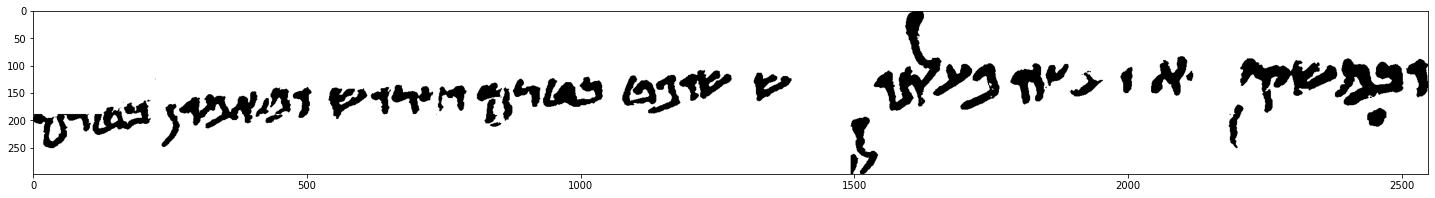

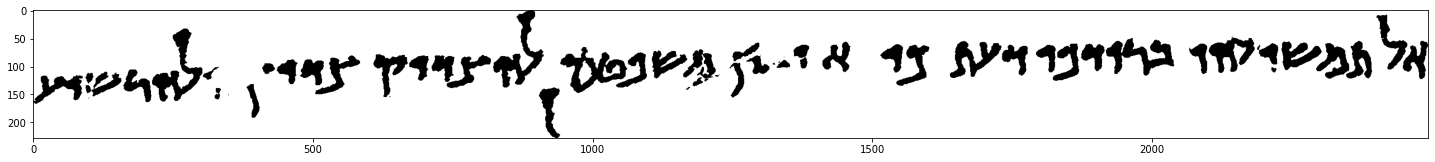

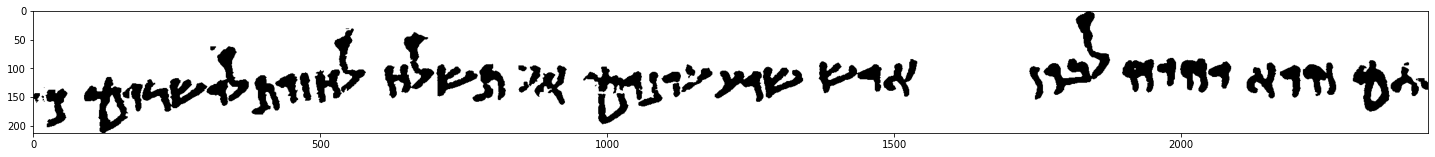

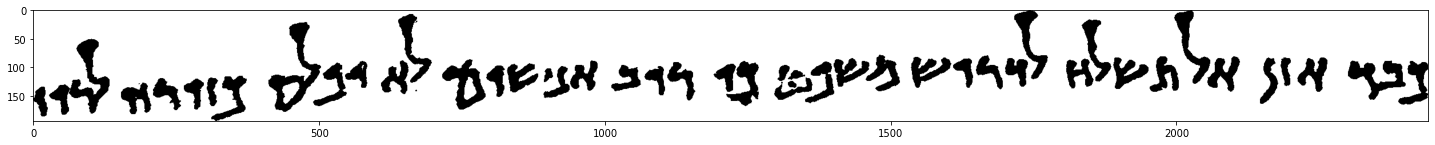

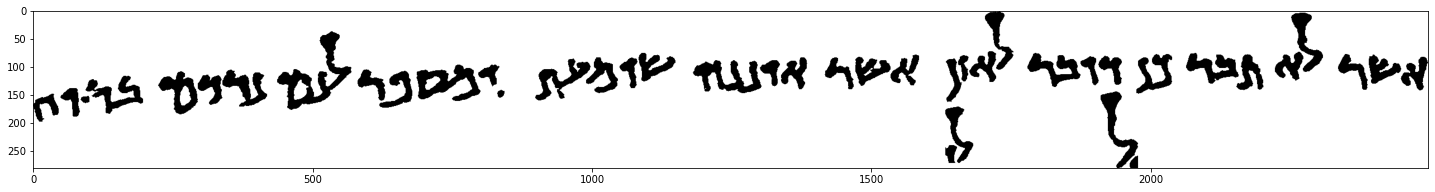

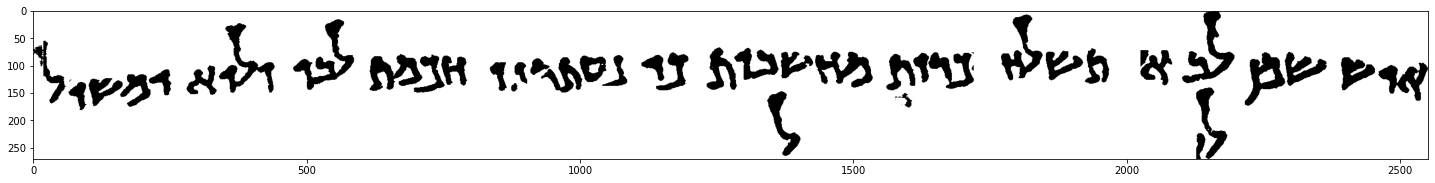

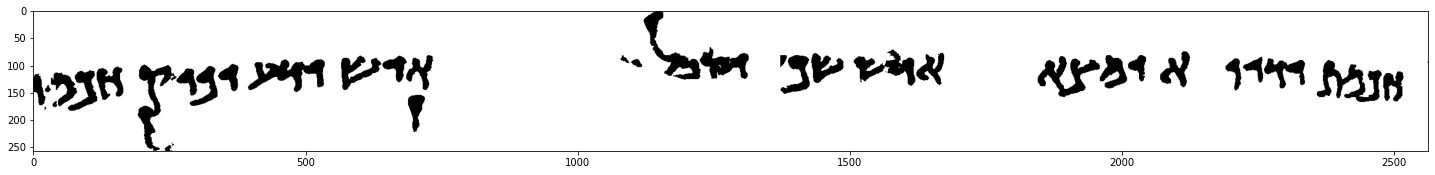

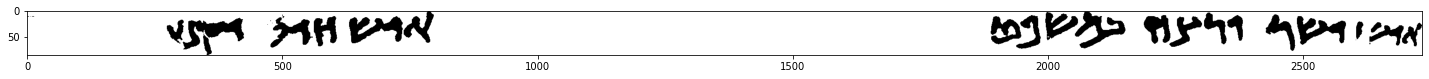

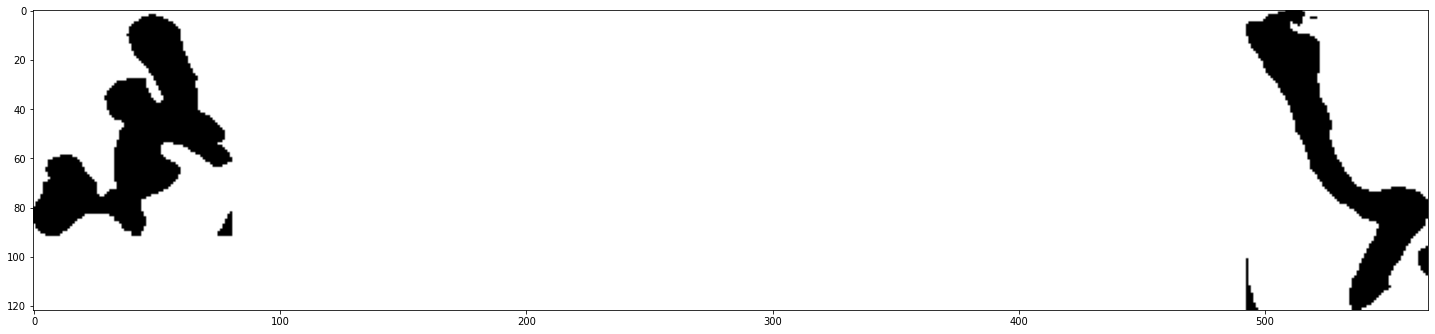

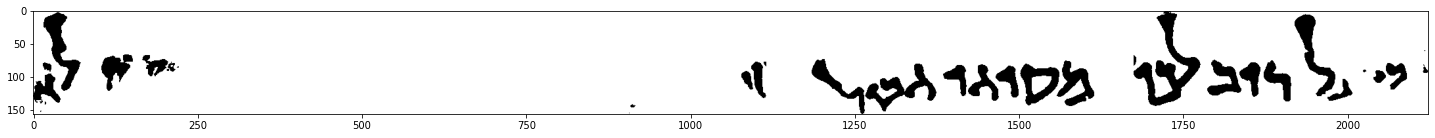

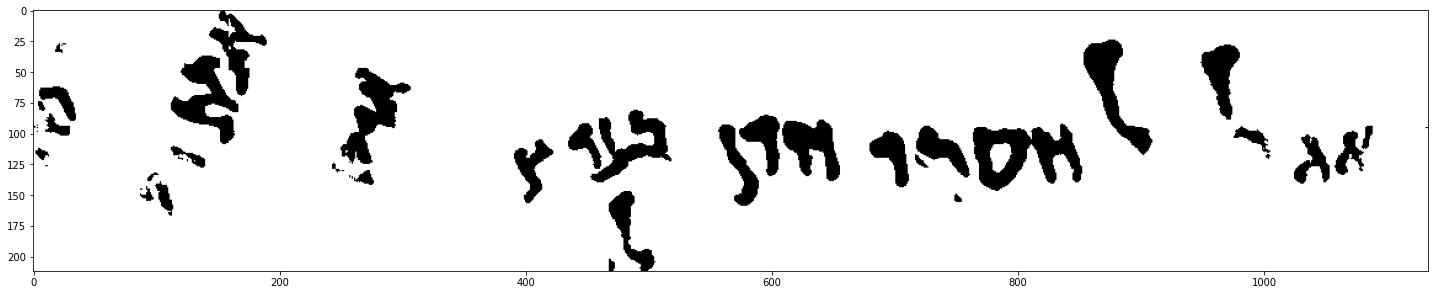

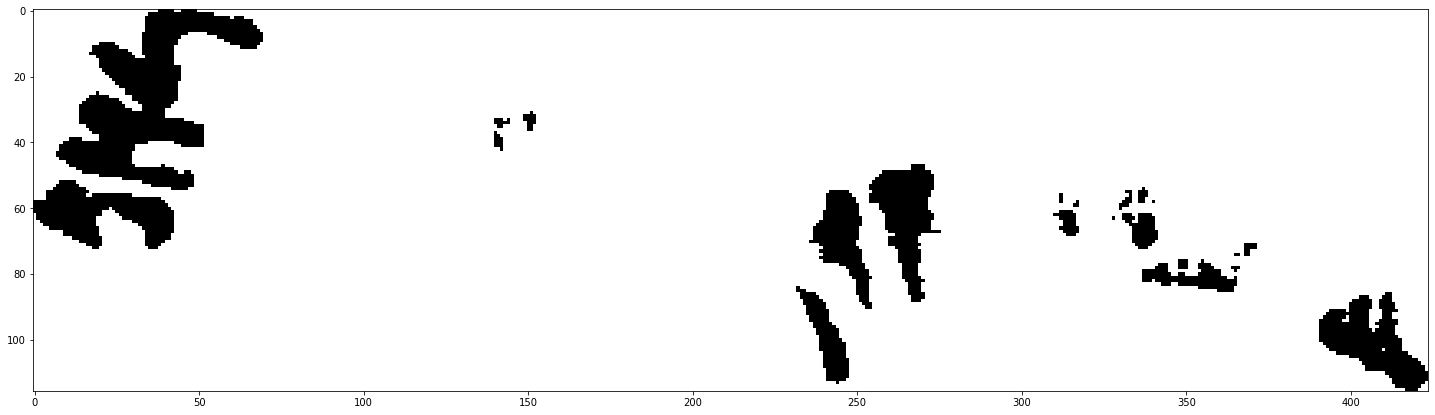

In [144]:
def skeletonize(image):
    skeleton = np.zeros(image.shape, np.uint8)
    se = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
    while True:
        opened = cv.morphologyEx(image, cv.MORPH_OPEN, se)
        temp = cv.subtract(image, opened)
        eroded = cv.erode(image, se)
        skeleton = cv.bitwise_or(skeleton, temp)
        image = eroded.copy()
        if cv.countNonZero(image) == 0:
            break

    return skeleton

def skeletonize_pass(image):
    skeleton = np.zeros(image.shape, np.uint8)
    se = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
    opened = cv.morphologyEx(image, cv.MORPH_OPEN, se)
    temp = cv.subtract(image, opened)
    eroded = cv.erode(image, se)
    skeleton = cv.bitwise_or(skeleton, temp)
    return skeleton

def test():
    img, d = line_segment_image(cv.imread(IMG_PATH), cc_min_a=1)
    for im in img:
        pimg(im, cmap='binary')


test()

In [295]:
from imutils import rotate_bound, rotate

def crop(image):
    coords = cv.findNonZero(image)
    x,y,w,h = cv.boundingRect(coords)
    return image[y:y+h, x:x+w], (x,y,w,h)

def consecutive(array):
    return np.split(array, np.where(np.diff(array) != 1)[0]+1)

def reduce_optimally(image, axis=0):
    best = 0
    reductions = []
    for angle in range(-20, 20, 2):
        # print(best, angle)
        # print(image.shape)
        rotated = rotate(image, angle)
        # print('shape:',rotated.shape)
        # cropped, dims = crop(rotated)
        # if len(cropped) == 0:
        #     print("image contains only black pixels!")
        #     return None
        reduced = cv.reduce(rotated // 255, axis, cv.REDUCE_SUM, dtype=cv.CV_32S).flatten()
        _, minima = peakdetect(reduced, lookahead=60, delta=0)
        # fig,(ax1, ax2) = plt.subplots(1, 2)
        # ax1.imshow(cropped, cmap='binary')
        # ax2.plot(reduced)
        # plt.show()
        # curr = len(consecutive(np.argwhere(reduced[30:-30]<=10).flatten()))
        candidates = [minimum for minimum in minima if minimum[1] <= 30]
        # print(f'a{angle}: {candidates}')
        curr = len(candidates)
        if curr > best:
            best = curr
            reductions = [(angle, candidates, (0,0,0,0))]
        elif 0 < best == curr:
            reductions.append((angle, candidates, (0,0,0,0)))

    if not reductions:
        print("could not find any peaks!")
        return None
    print(reductions[len(reductions) // 2])
    return reductions[len(reductions) // 2]

https://math.stackexchange.com/questions/1064832/rotate-a-line-by-a-given-angle-about-a-point
https://www.desmos.com/calculator/jn7yhrvutv

In [283]:
def rotated_line_eq(shape, angle, axis, val):
    y0 = shape[0] // 2
    x0 = shape[1] // 2
    angle = angle * (np.pi / 180)
    val *= -1
    if axis == 0:
        return \
            lambda x: x, \
            lambda y: int(round(-(((np.cos(angle) * (y - y0)) + y0 + val) / np.sin(angle)) + x0))
    if axis == 1:
        return \
            lambda x: int(round(-(((np.sin(angle) * (x - x0)) + y0 + val) / np.cos(angle)) + y0)), \
            lambda y: y

def equations_from_reductions(image, angle, candidates, dimensions, axis):
    # where_zeros = np.argwhere(reductions<=10).flatten()
    # line_breaks = [int(np.mean(x)) for x in consecutive(where_zeros)]
    # _, minima = peakdetect(candidates, lookahead=40, delta=10)
    line_breaks, magnitudes = zip(*candidates)
    for line_break in line_breaks:
        # line_break += dimensions[axis] // 2
        yield rotated_line_eq(image.shape, -angle, axis, line_break)

def rot_from_red(image, angle, candidates, dimensions, axis):
    # where_zeros = np.argwhere(reduced<=10).flatten()
    # consecutive_zeros = np.split(where_zeros, np.where(np.diff(where_zeros) != 1)[0]+1)
    # line_breaks = [int(np.mean(x)) for x in consecutive_zeros]
    line_breaks, magnitudes = zip(*candidates)
    img_rot = rotate(image, angle)
    try:
        img_rot = cv.cvtColor(img_rot, cv.COLOR_GRAY2RGB)
    except:
        pass
        # print('couldnt change color')
    for line_break  in line_breaks:
        line_break += dimensions[axis] // 2
        pt1 = [0,0]
        pt2 = [img_rot.shape[axis], img_rot.shape[axis]]
        pt1[axis] = line_break
        pt2[axis] = line_break
        cv.line(img_rot, tuple(pt1), tuple(pt2), (0,255,0))
    return img_rot

def test_rot(axis=1):
    im = cv.imread(IMG_PATH)
    im = preprocessed(im)
    im, d = crop(im)
    im = im[0:352, 615:1230]
    im, d = crop(im)
    print(im.shape)
    reductions = reduce_optimally(im, axis=axis)
    rim = rot_from_red(im, *reductions, axis=axis)
    pimg(rim)
    eqs = equations_from_reductions(im, *reductions, axis=axis)
    im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    for x,y in eqs:
        print(x(0), y(0))
        cv.line(im, (y(0), x(0)), (y(im.shape[1]), x(im.shape[1])), (0, 255, 0), 1)
    pimg(im)

test_rot()

IndentationError: expected an indented block (2585546864.py, line 34)

In [61]:
from dataclasses import dataclass

@dataclass
class Rect:
    x: int
    y: int
    w: int
    h: int

In [69]:
def to_grid(image, n_rows, n_cols):
    h = image.shape[0]
    w = image.shape[1]
    m = h // n_rows
    n = w // n_cols
    tiles = []
    for r, y in enumerate(range(0, h, m)):
        for c, x in enumerate(range(0, w, n)):
            tile = image[y:y+m, x:x+n]
            rect = Rect(x=x, y=y, w=n, h=m)
            tiles.append((rect, tile))

    return tiles

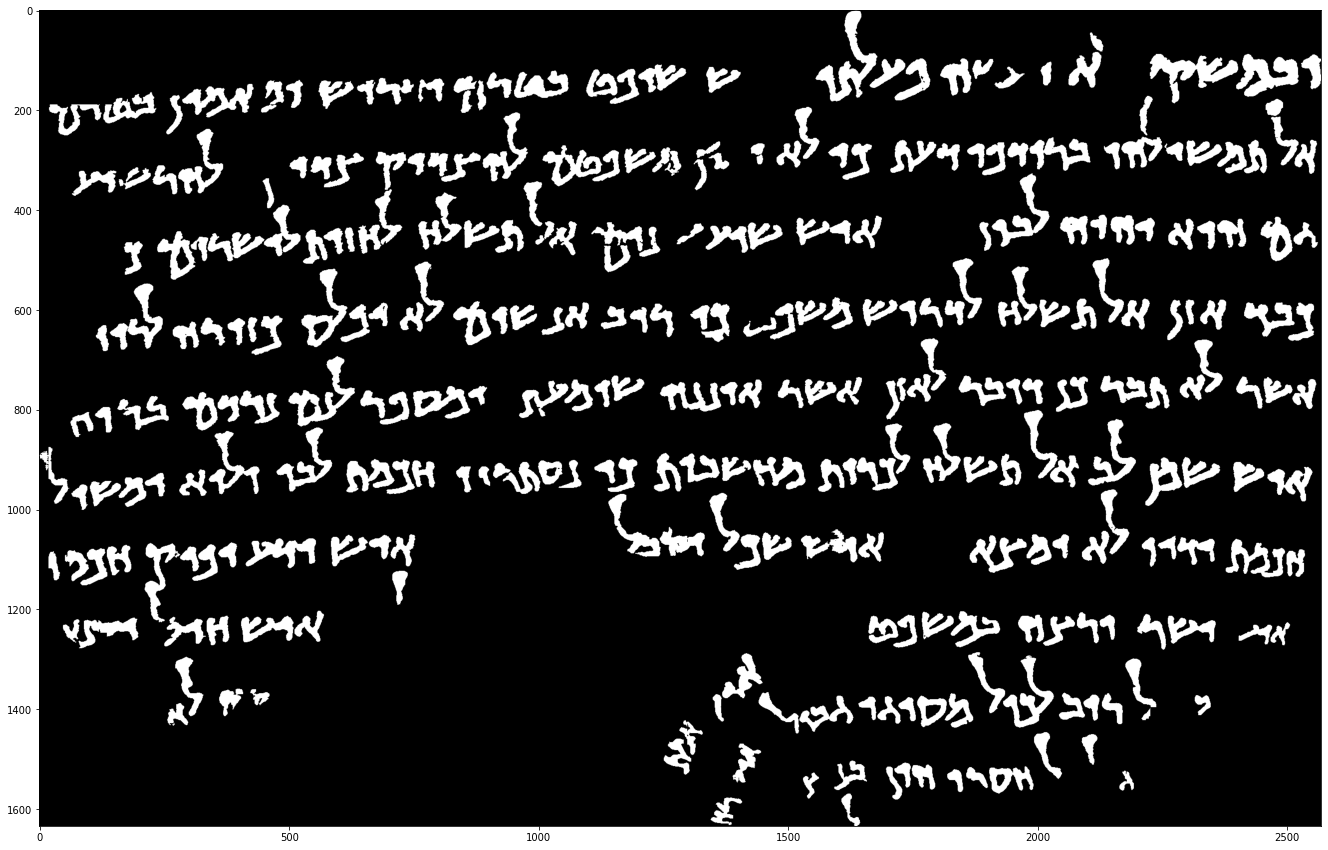

(-2, [[281, 13], [578, 28], [683, 0]], (0, 0, 0, 0))
couldnt change color


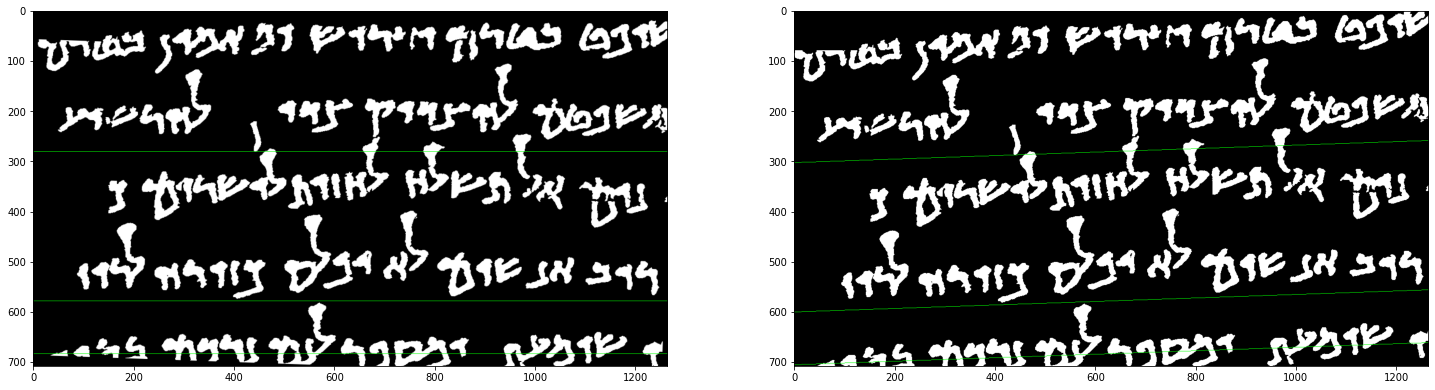

(0, [[251, 25], [393, 9], [496, 24], [715, 19]], (0, 0, 0, 0))
couldnt change color


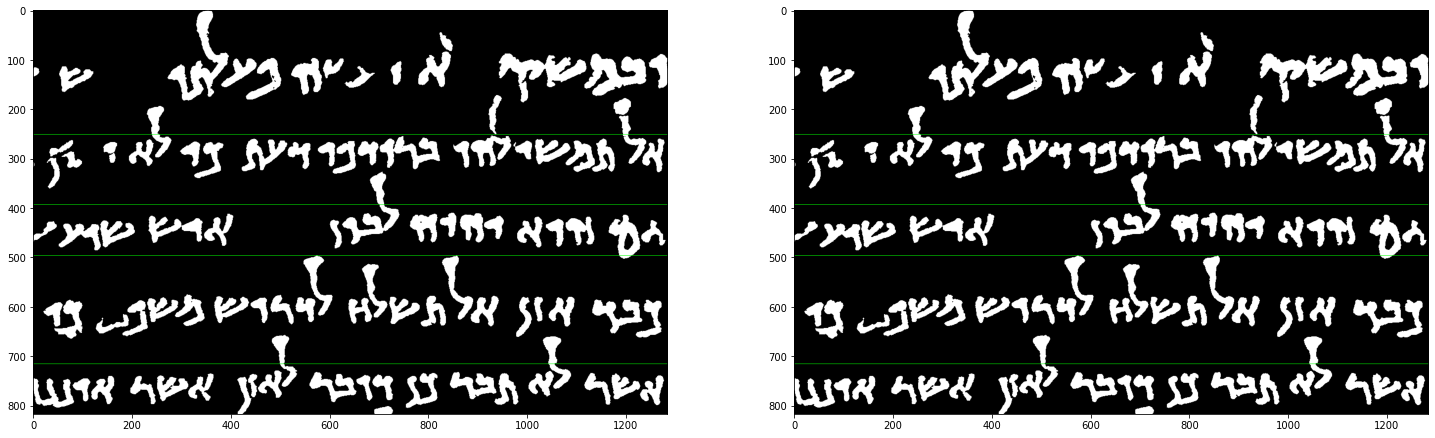

could not find any peaks!
(0, [[57, 25], [217, 7], [382, 11], [461, 0]], (0, 0, 0, 0))
couldnt change color


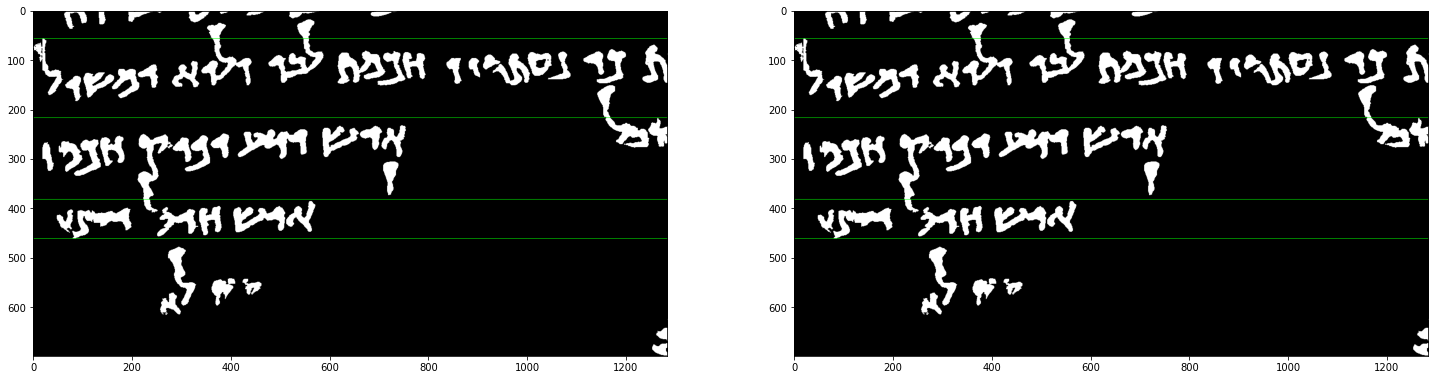

(2, [[169, 14], [322, 0], [467, 0]], (0, 0, 0, 0))
couldnt change color


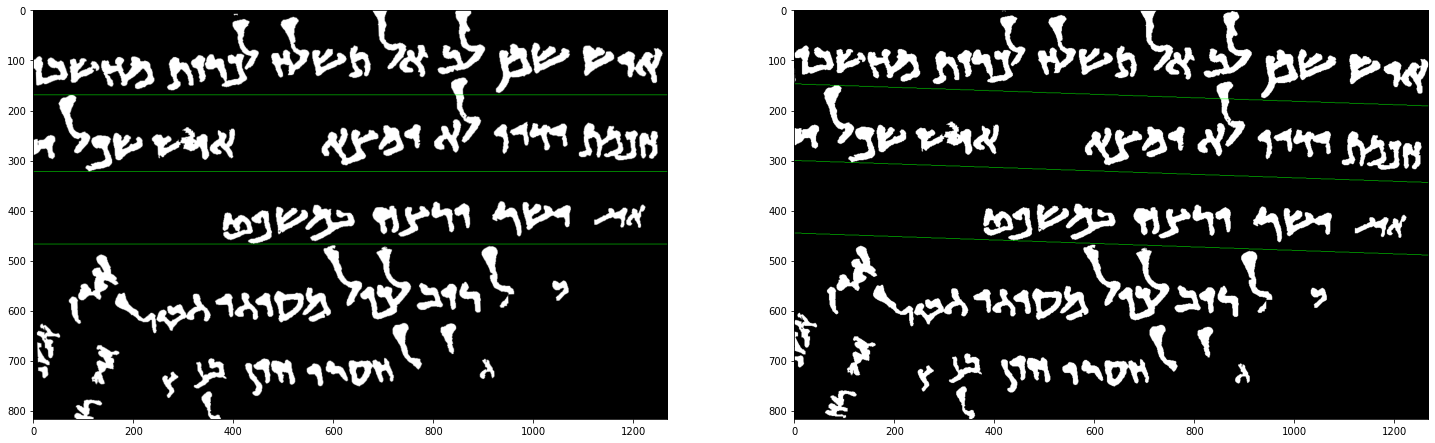

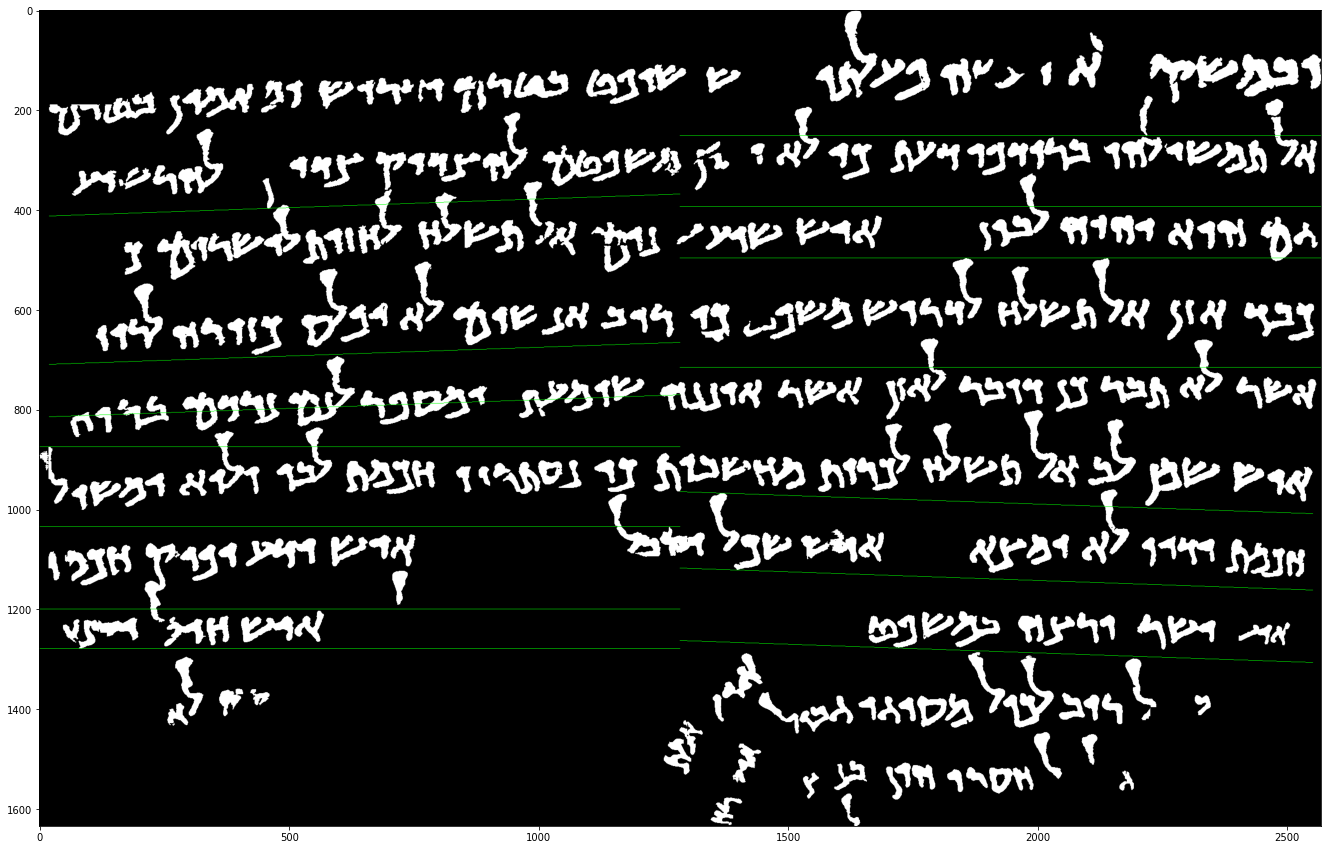

In [297]:
def test(axis=1):
    im = cv.imread(IMG_PATH)
    im = preprocessed(im)
    ccs = get_ccs_from_image(im)
    extreme_ccs = [cc for cc in ccs if cc.a < 500]
    for cc in extreme_ccs:
        im[cc.y:cc.y+cc.h, cc.x:cc.x+cc.w] = np.zeros((cc.h, cc.w))
    im, d = crop(im)
    pimg(im)
    tiles = to_grid(im, 2, 2)
    im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    i=0
    for (pos, tile) in tiles:
        if cv.countNonZero(tile) < 5:
            continue
        reductions = reduce_optimally(tile, axis=axis)
        tile, tile_dim = crop(tile)
        tile = cv.cvtColor(tile, cv.COLOR_GRAY2RGB)
        if reductions:
            i+=1
            path = f'/home/jsk/Study/2-4-hwr/Handwriting_Recognition/jesper_tests/out/{i}.jpg'
            rotim = rot_from_red(tile, *reductions, axis=axis)
            # print(f"writing to {path}")
            cv.imwrite(path, rotim)
            eqs = equations_from_reductions(tile, *reductions, axis=axis)
            for x,y in eqs:
                x_offset = pos.x + tile_dim[0]
                y_offset = pos.y + tile_dim[1]
                cv.line(tile, (y(0), x(0)), (y(tile.shape[1]), x(tile.shape[1])), (0, 255, 0), 1)
                cv.line(im, (y(0)+x_offset, x(0)+y_offset), (y(tile.shape[1])+x_offset, x(tile.shape[1])+y_offset), (0, 255, 0), 1)
            # print(r)
            fig, (a1, a2) = plt.subplots(1, 2)
            a1.imshow(rotim, cmap='binary')
            a2.imshow(tile, cmap='binary')
            plt.show()
            # pimg(tile)
    pimg(im)

test()